In [1]:
import os
import random
import string
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
from io import BytesIO
from toolz.curried import *
import requests

In [2]:
! pip install fonttools
from fontTools.ttLib import TTFont
from fontTools.unicode import Unicode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
paths = {
  'fonts': os.path.join('ocr-digital-display','synthetic-data-generation', 'fonts')
}

In [4]:
def get_wordlist():
  word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
  response = requests.get(word_site)
  return response.content.splitlines()

WORDS = get_wordlist()
ALPHAS = [':', '.'] # TODO: &

def char_list():
  return concatv(
      string.ascii_letters,
      string.digits,
      ALPHAS
  )

def supported_chars(ttfont):
  return pipe(
    ttfont,
    lambda f: f['cmap'].tables,
    map(lambda x: x.cmap.items()),
    merge,
    lambda d: list(d.keys()),
    filter(lambda char_code: chr(char_code) in char_list()),
    list
  )

def is_supported(charset, font):
  return set(
      map(ord)(charset)
    ).issubset(supported_chars(font))
    
def random_string_from_charset(charset):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: random.choice(charset)),
      reduce(lambda a, b: str(a) + str(b)),
  )

def random_digits():
  return random_string_from_charset(string.digits)

def random_word():
  return pipe(
      WORDS,
      random.choice,
      lambda bs: bs.decode("utf-8") 
  )

# TODO: test curry
def supported_filter(font):
  def test(string):
    return is_supported(string, font)
  return test

def sample_text(font):
  return pipe([
      random_string_from_charset(list(string.digits) + ALPHAS),
      random_word(),
      random_digits()
    ],
    filter(supported_filter(font)),
    list,
    random.choice
  )

In [ ]:
# TODO: unused
def is_digits_supported(font):
  return is_supported(string.digits, font)

# TODO: unused
def is_letters_supported(font):
  return is_supported(string.ascii_letters, font)

# TODO: unused
def is_alphas_supported(font):
  return is_supported(ALPHAS, font)

# TODO: unused
def random_gibberish(font):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: chr(random.choice(supported_chars(font)))),
      reduce(lambda a, b: str(a) + str(b)),
  )

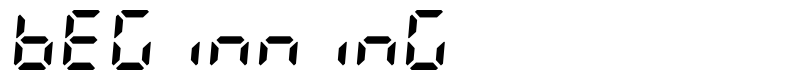

beginning


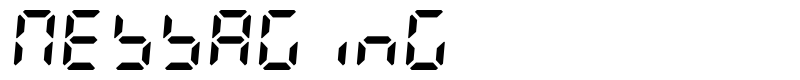

messaging


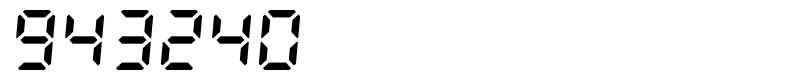

943240


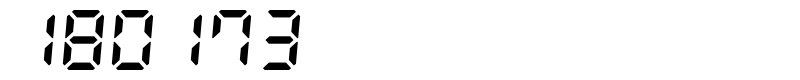

180173


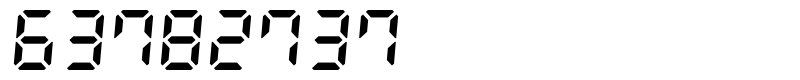

63782737


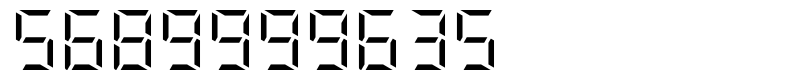

5689999635


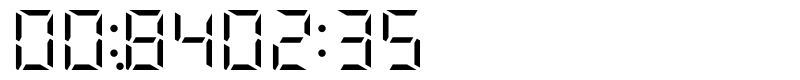

00:.8402:35


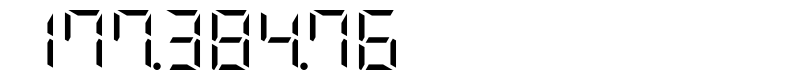

177.384.76


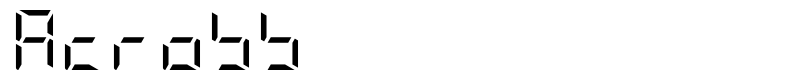

across


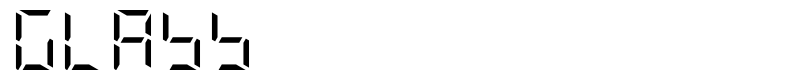

glass


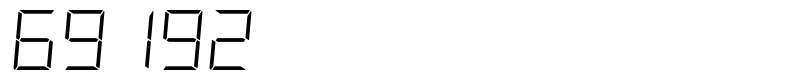

69192


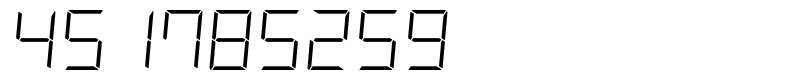

451785259


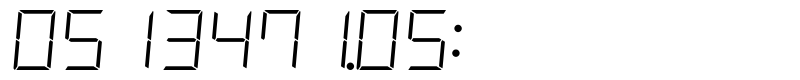

0513471.05:


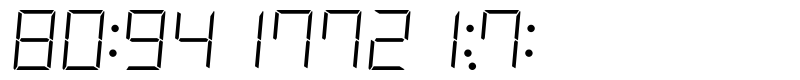

80:9417721:.7:


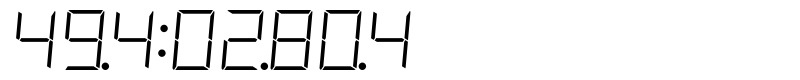

49.4:02.80.4


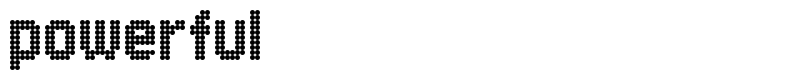

powerful


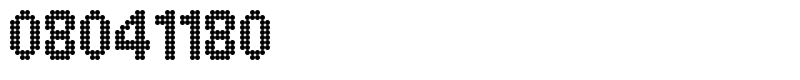

08041180


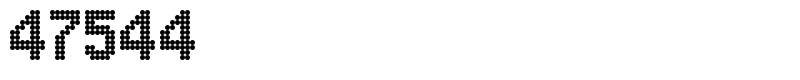

47544


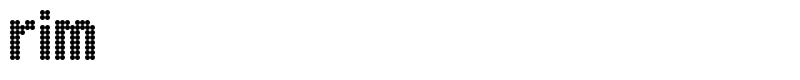

rim


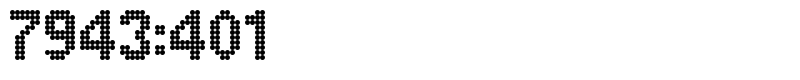

7943:401


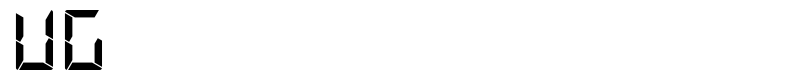

vg


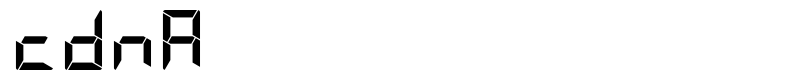

cdna


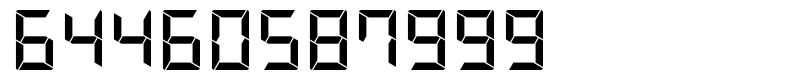

64460587999


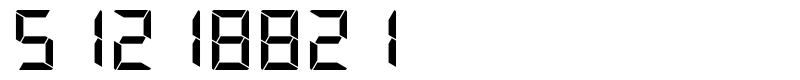

51218821


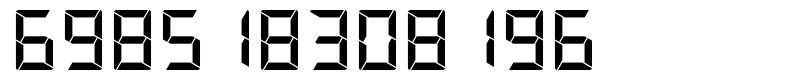

698518308196


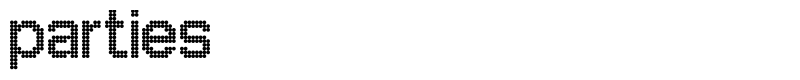

parties


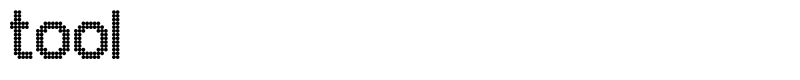

tool


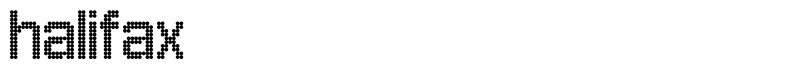

halifax


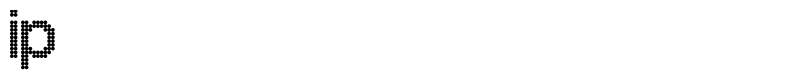

ip


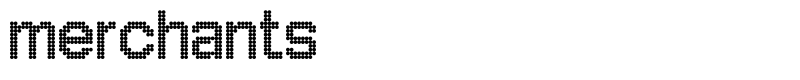

merchants


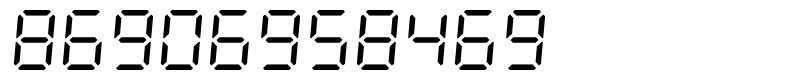

86906958469


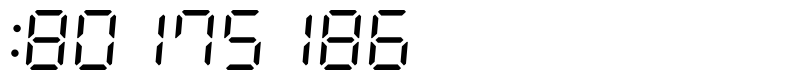

:80175186


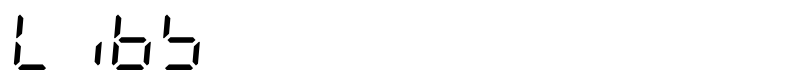

libs


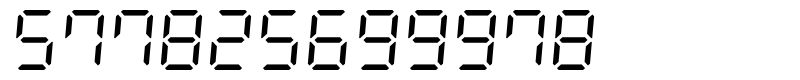

577825699978


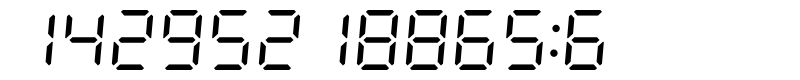

14295218865:6


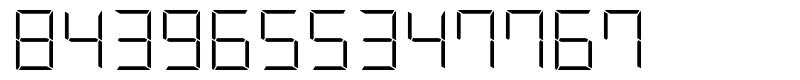

8439655347767


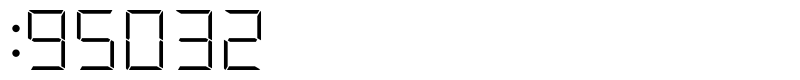

:95032


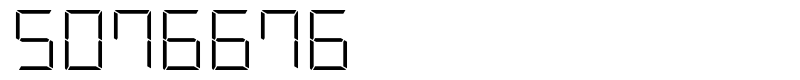

5076676


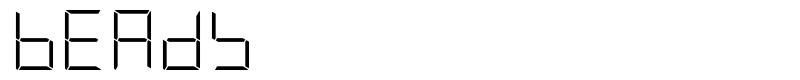

beads


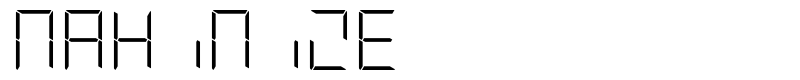

maximize


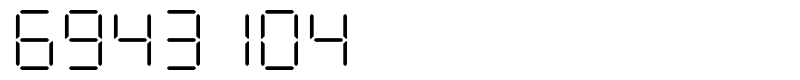

6943104


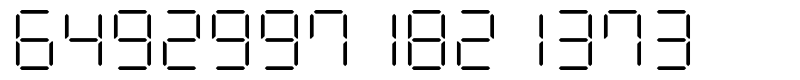

64929971821373


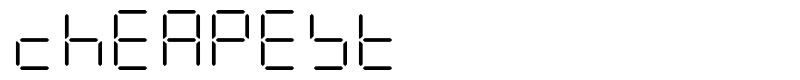

cheapest


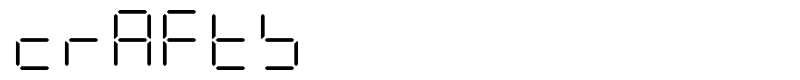

crafts


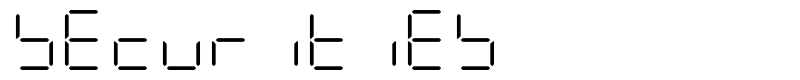

securities


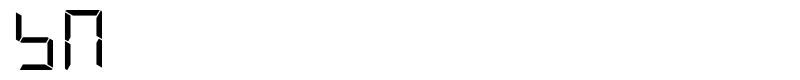

sm


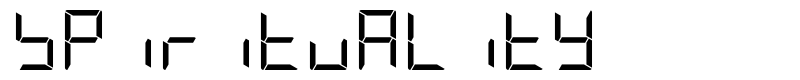

spirituality


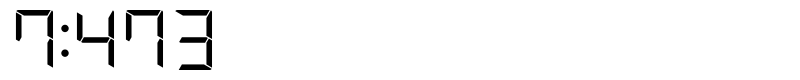

7:473


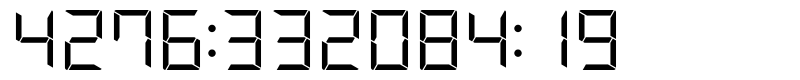

4276:332084:19


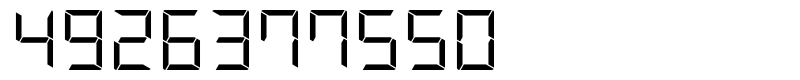

4926377550


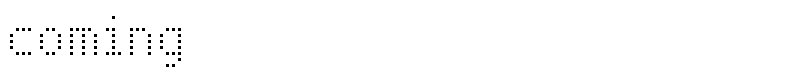

coming


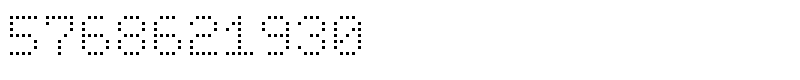

5768621930


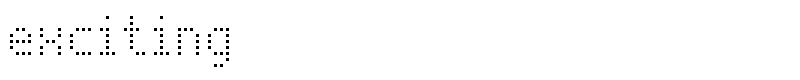

exciting


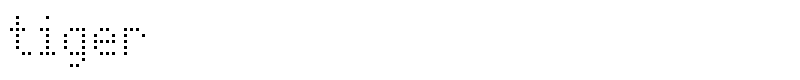

tiger


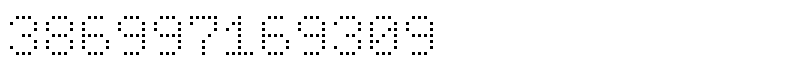

386997169309


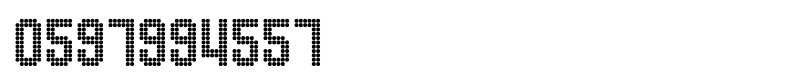

0597994557


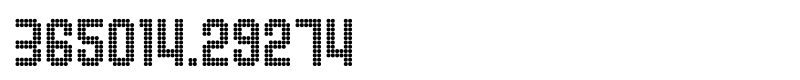

365014.29274


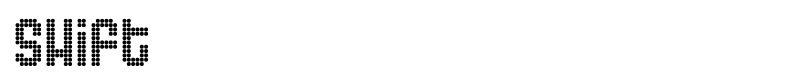

shift


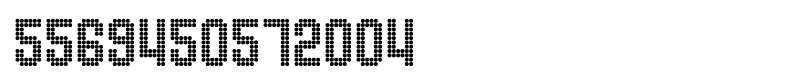

5569450572004


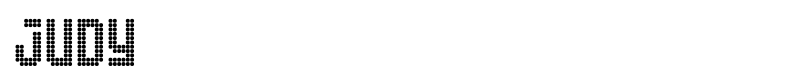

judy


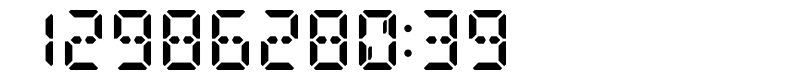

12986280:39


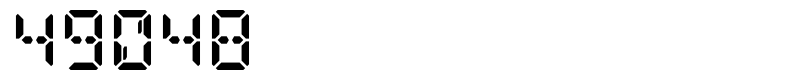

49048


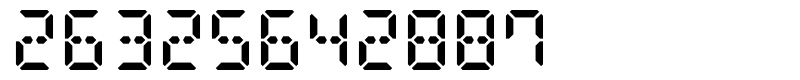

26325642887


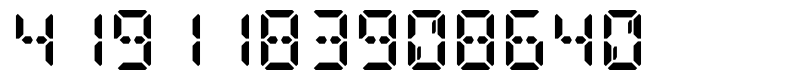

4191183908640


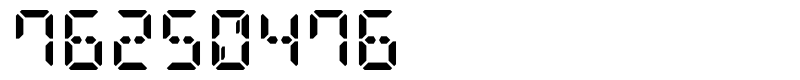

76250476


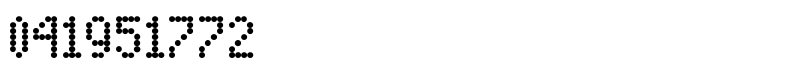

041951772


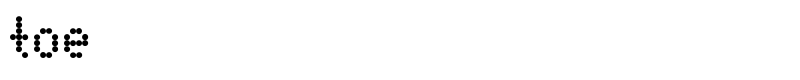

toe


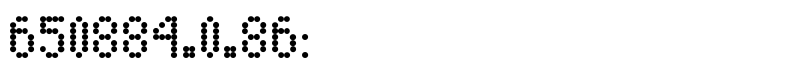

650884.0.86:


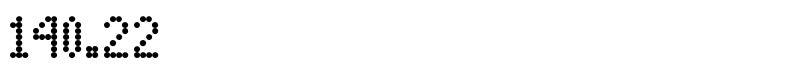

140.22


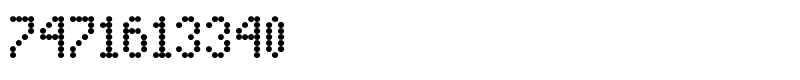

7471613340


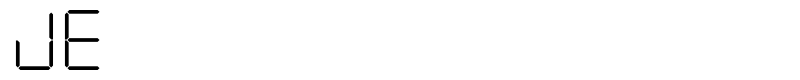

je


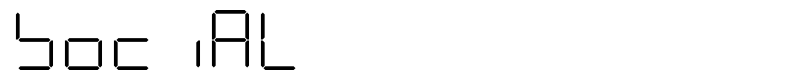

social


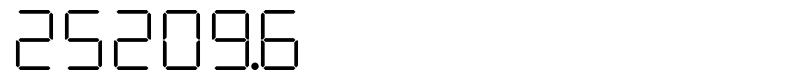

25209.6


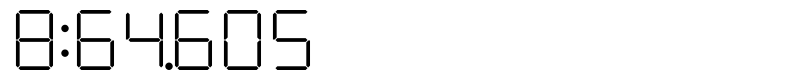

8:64.605


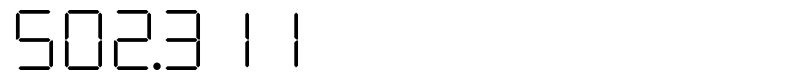

502.311


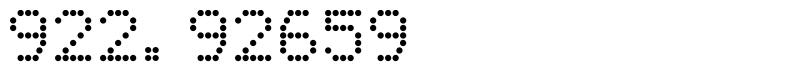

922.92659


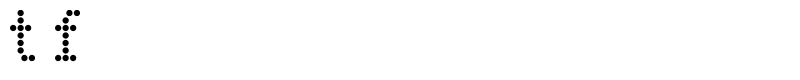

tf


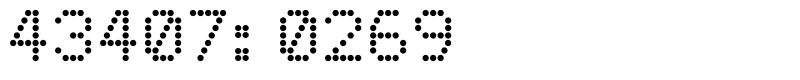

43407:0269


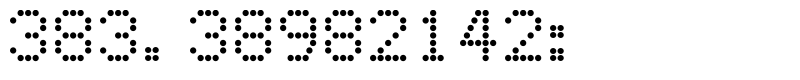

383.38982142:


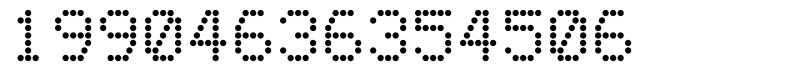

19904636354506


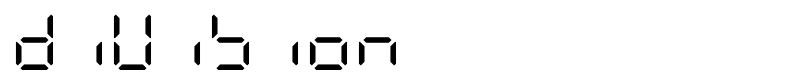

division


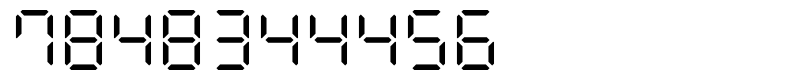

7848344456


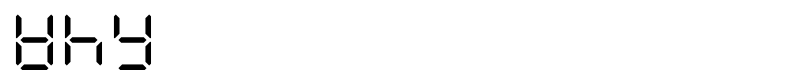

why


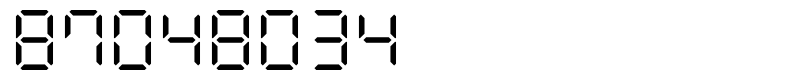

87048034


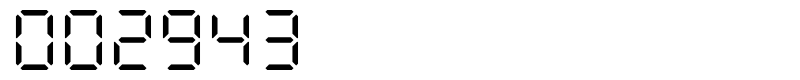

002943


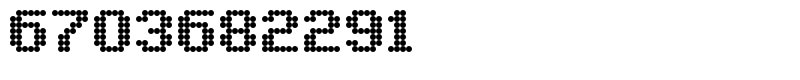

6703682291


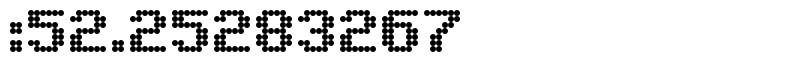

:52.25283267


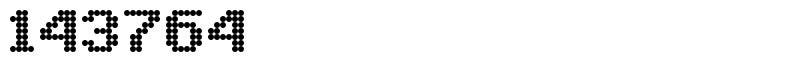

143764


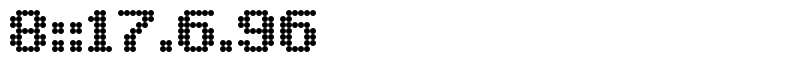

8::17.6.96


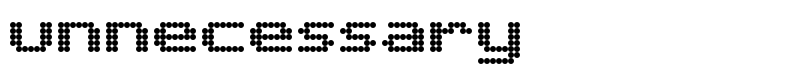

unnecessary


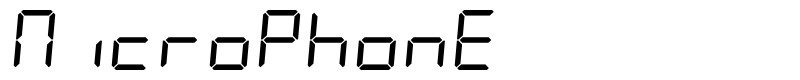

microphone


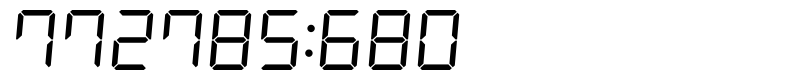

772785:680


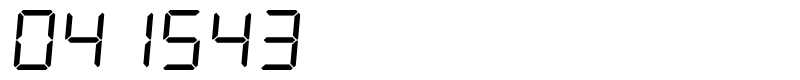

041543


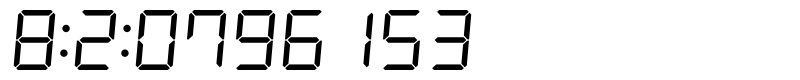

8:2:0796153


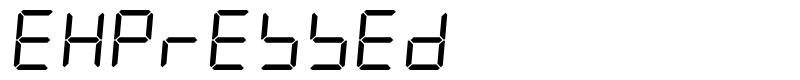

expressed


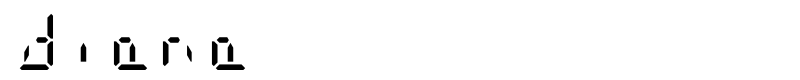

diana


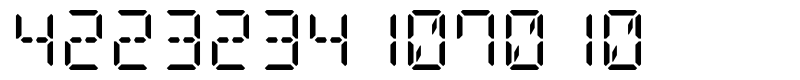

4223234107010


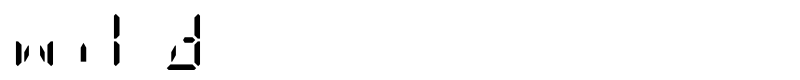

wild


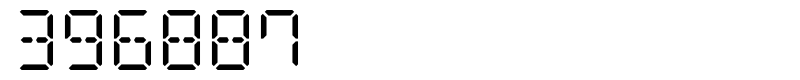

396887


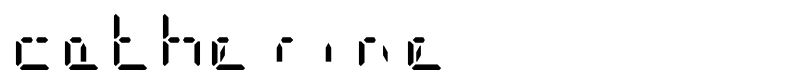

catherine


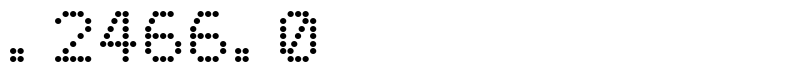

.2466.0


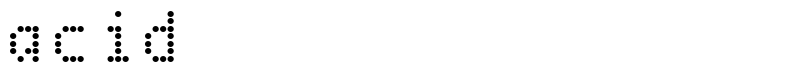

acid


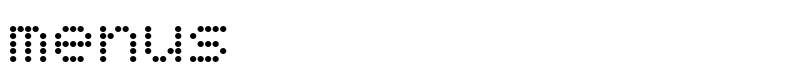

menus


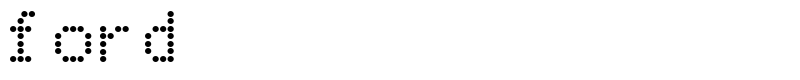

ford


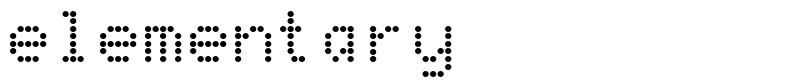

elementary


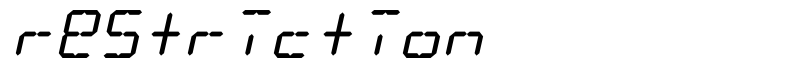

restriction


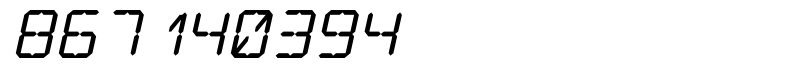

867140394


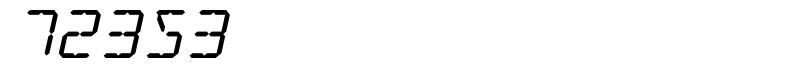

72353


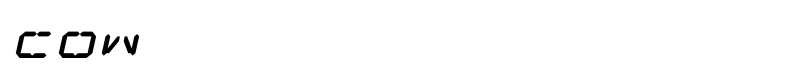

cow


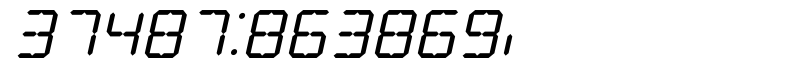

37487:863869.


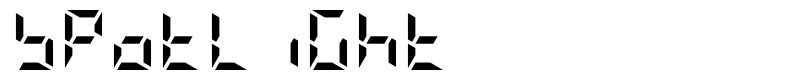

spotlight


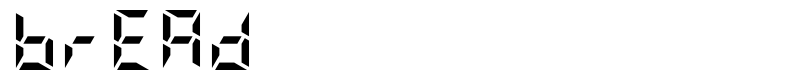

bread


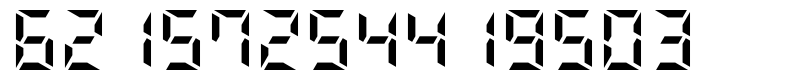

62157254419503


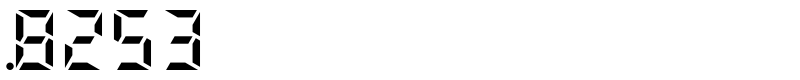

..8253


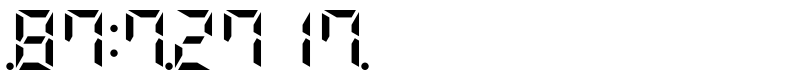

.87:7.2717.


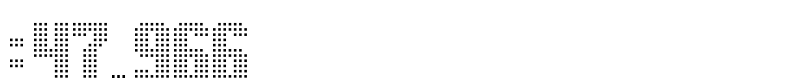

:47.966


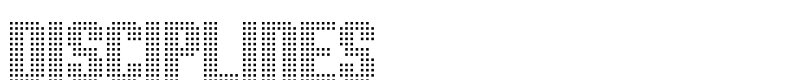

disciplines


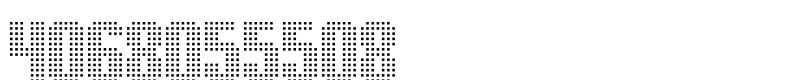

4068055508


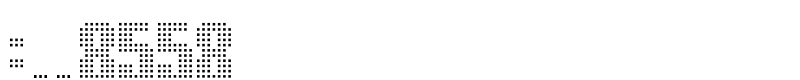

:..8558


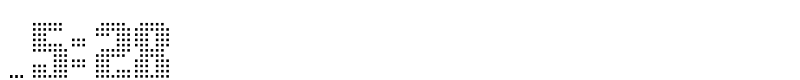

.5:28


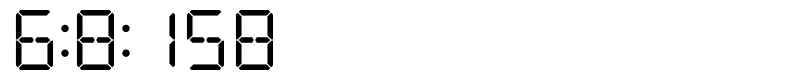

6:8:158


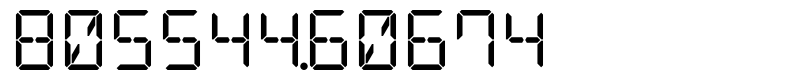

805544.60674


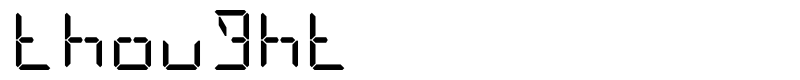

thought


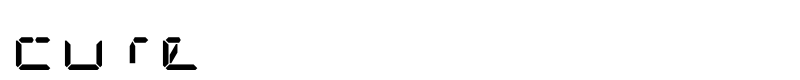

cure


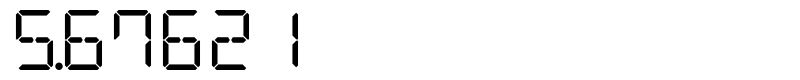

5.67621


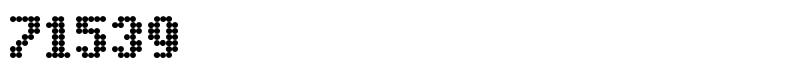

71539


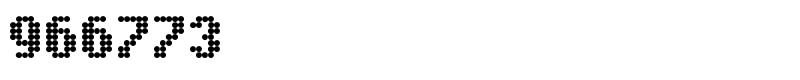

966773


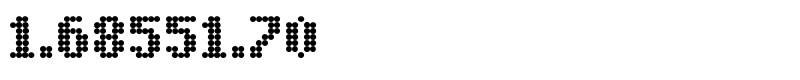

1.68551.70


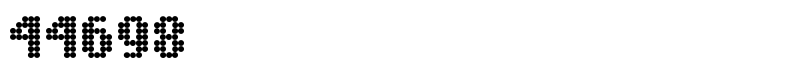

44698


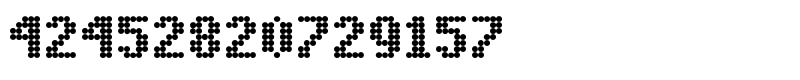

42452820729157


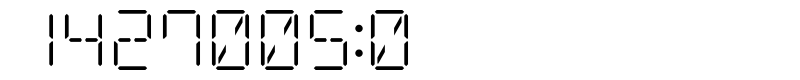

1427005:0


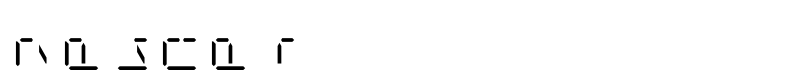

nascar


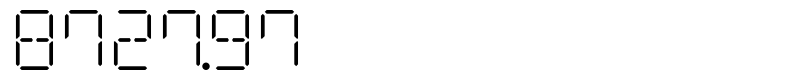

8727.97


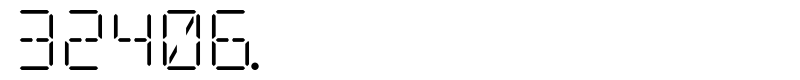

32406.


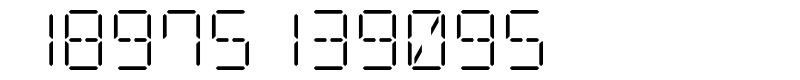

18975139095


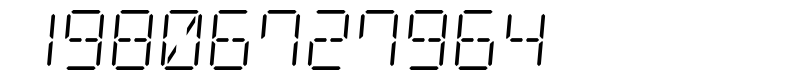

19806727964


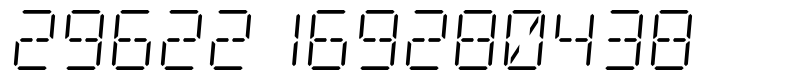

29622169280438


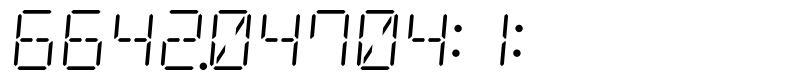

6642.04704:1:


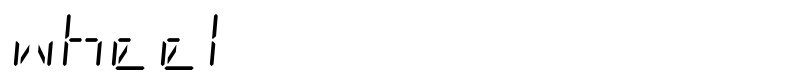

wheel


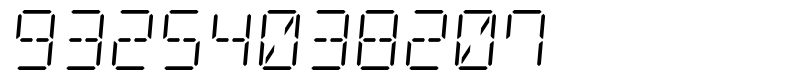

93254038207


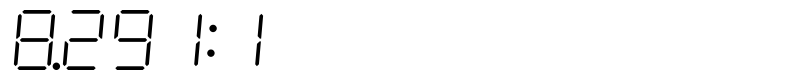

8.291:1


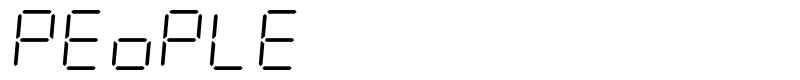

people


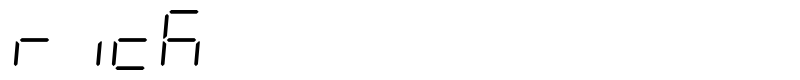

rick


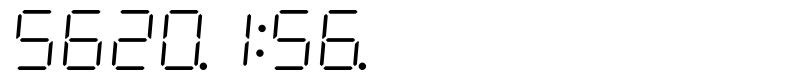

5620.1:56..


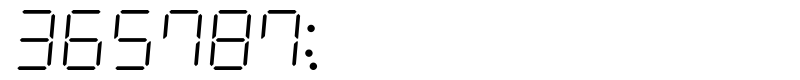

365787:.


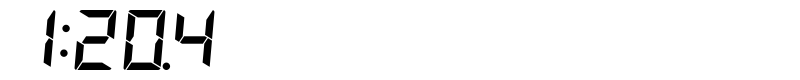

1:20.4


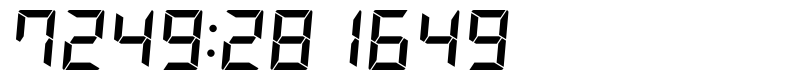

7249:281649


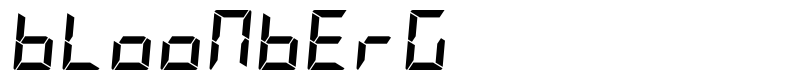

bloomberg


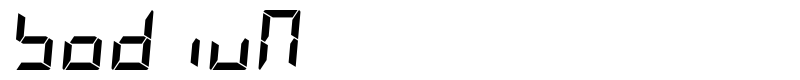

sodium


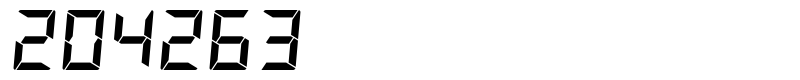

204263


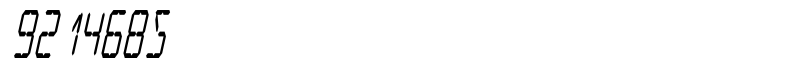

9214685


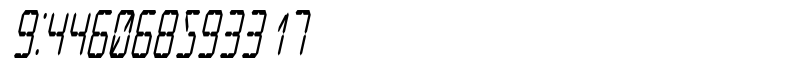

9:446068593317


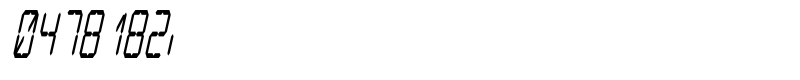

0478182.


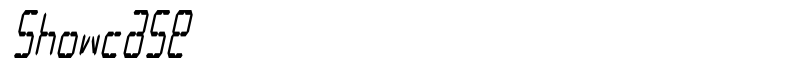

showcase


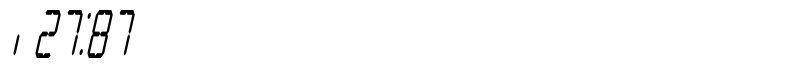

.27:87


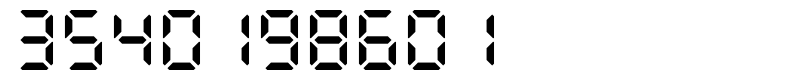

3540198601


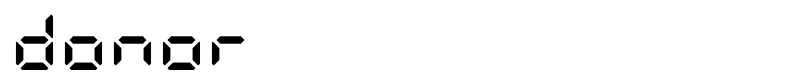

donor


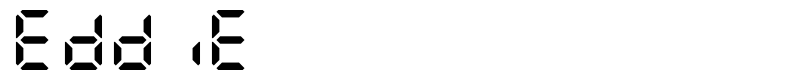

eddie


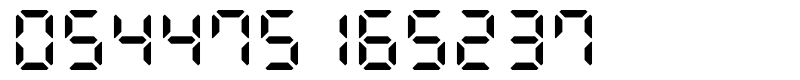

054475165237


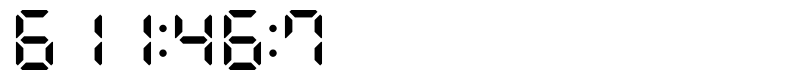

611:46:7


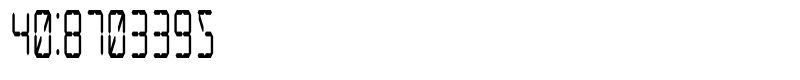

40:8703395


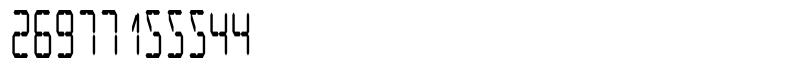

26977155544


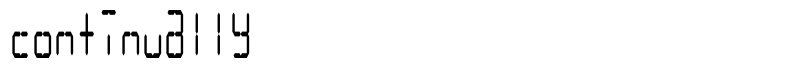

continually


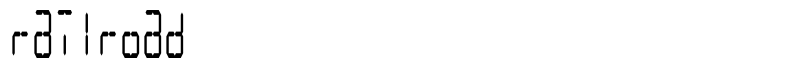

railroad


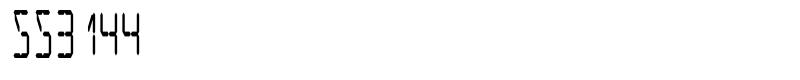

553144


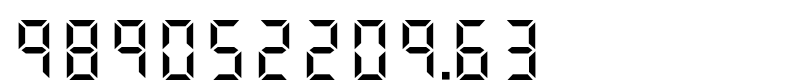

989052209.63


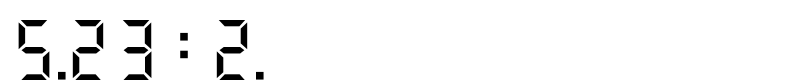

5.23:2.


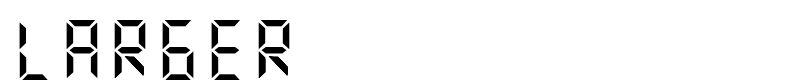

larger


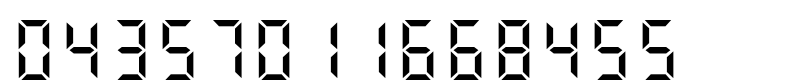

04357011668455


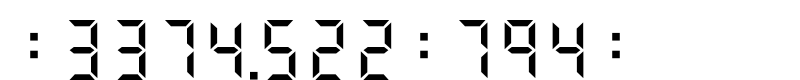

:3374.522:794:


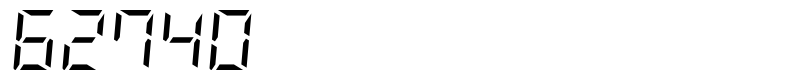

62740


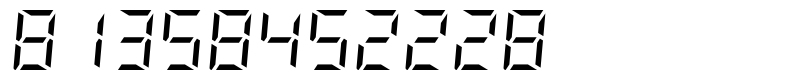

81358452228


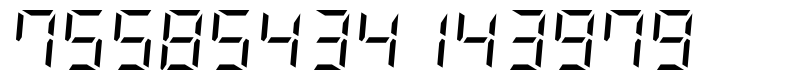

75585434143979


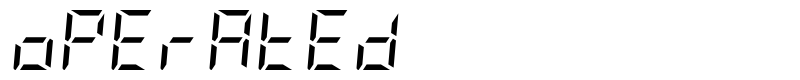

operated


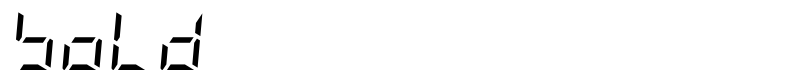

sold


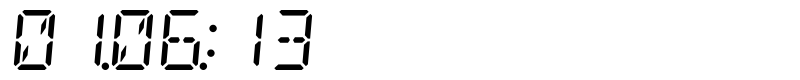

01.06.:13


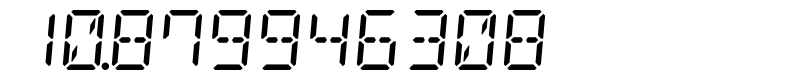

10.879946308


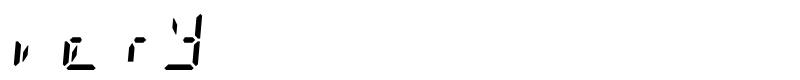

very


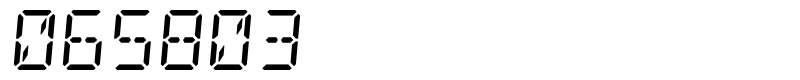

065803


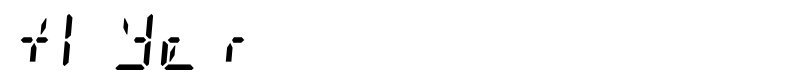

flyer


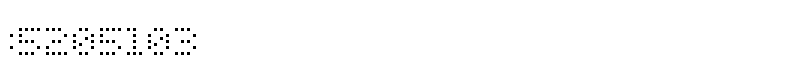

:5205103


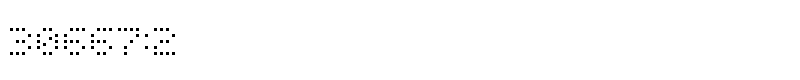

30667:2


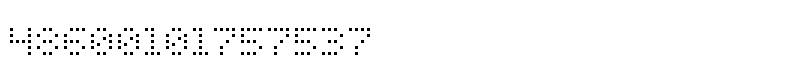

48600101757537


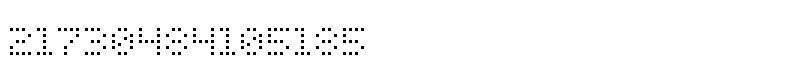

21730484105185


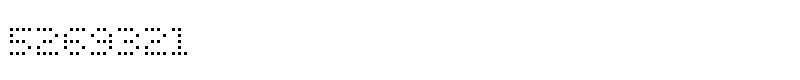

5269321


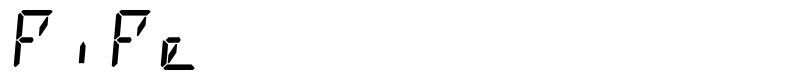

pipe


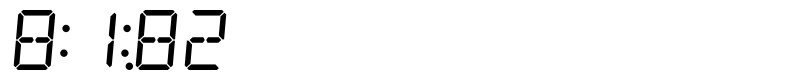

8:1:.82


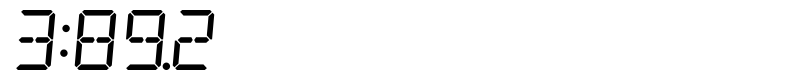

3:89.2


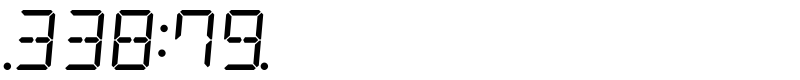

.338:79..


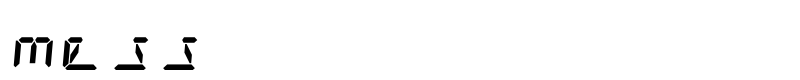

mess


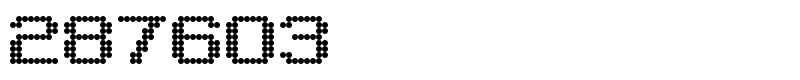

287603


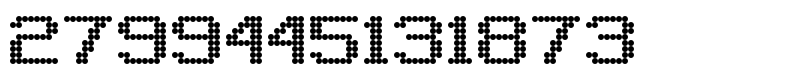

2799445131873


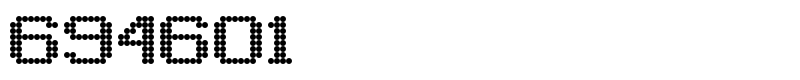

694601


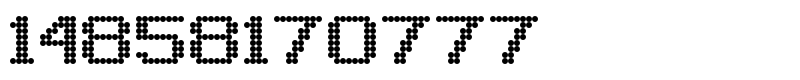

14858170777


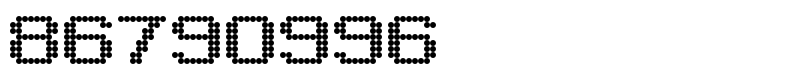

86790996


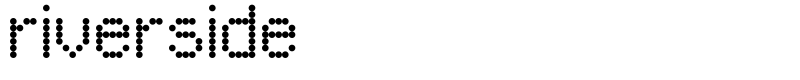

riverside


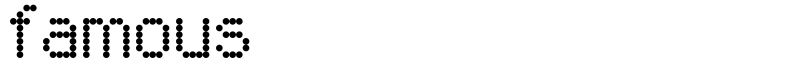

famous


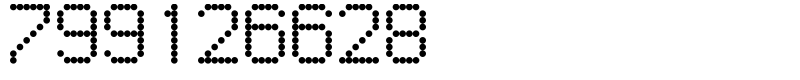

799126628


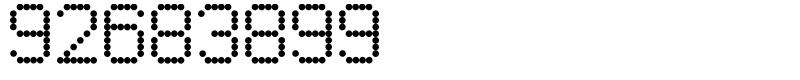

92683899


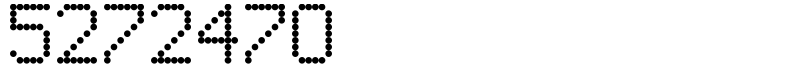

5272470


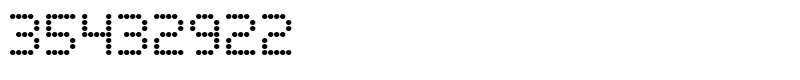

35432922


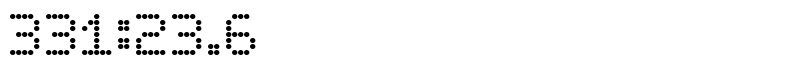

331:23.6


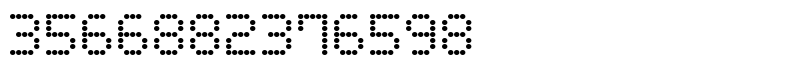

3566882376598


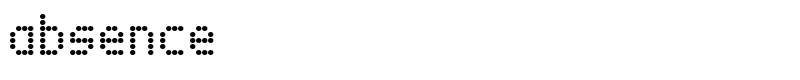

absence


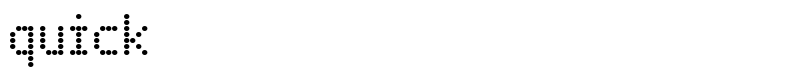

quick


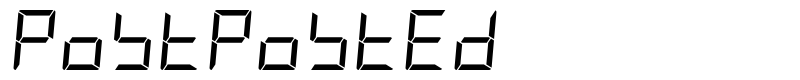

postposted


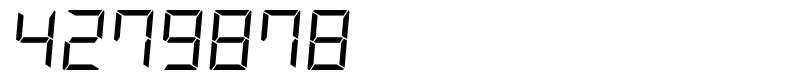

4279878


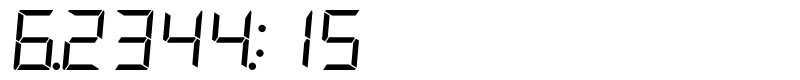

6.2344.:15


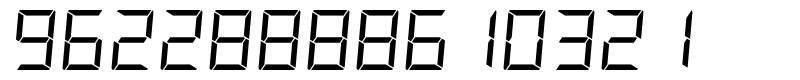

96228888610321


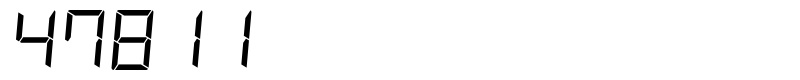

47811


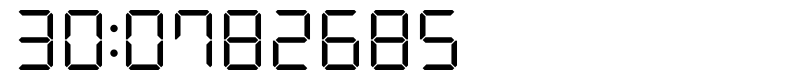

30:0782685


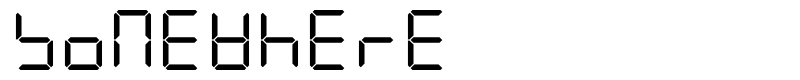

somewhere


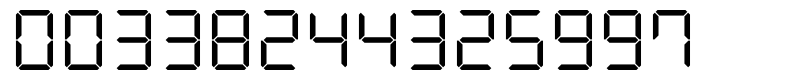

00338244325997


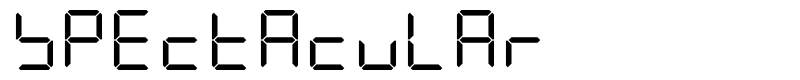

spectacular


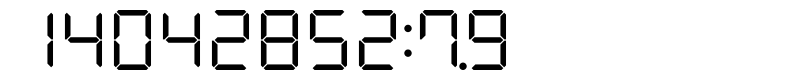

14042852:7.9


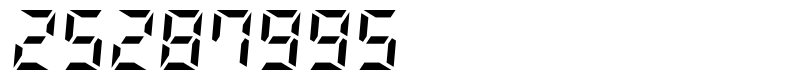

25287995


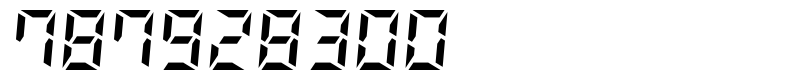

787928300


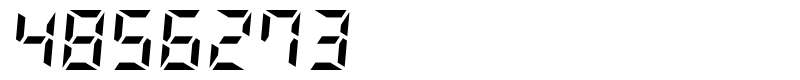

4856273


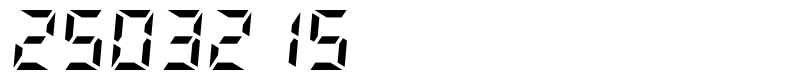

2503215


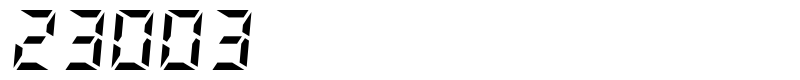

23003


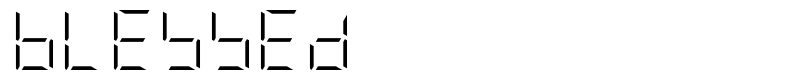

blessed


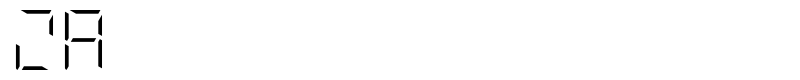

za


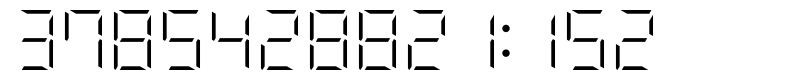

3785428821:152


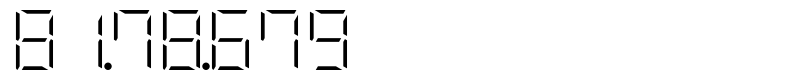

81.78.679


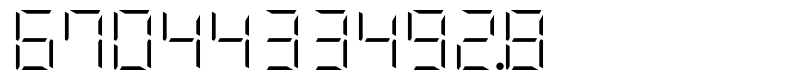

6704433492.8


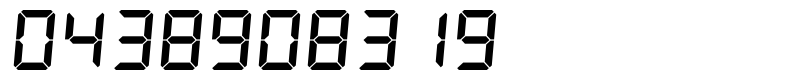

0438908319


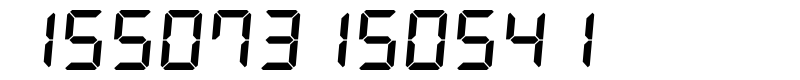

155073150541


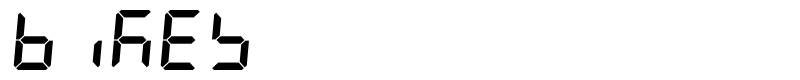

bikes


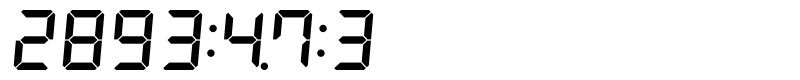

2893:4..7:3


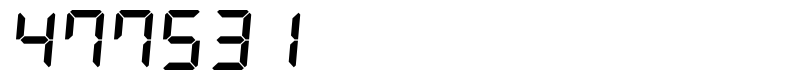

477531


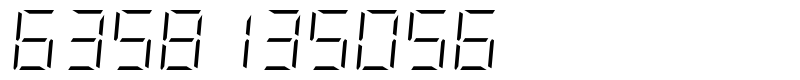

6358135056


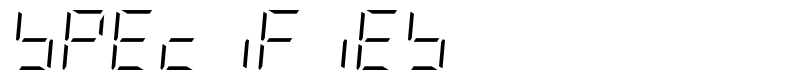

specifies


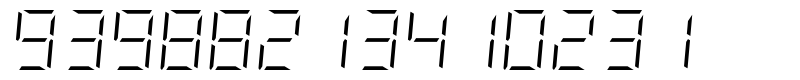

93988213410231


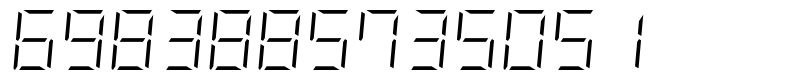

6983885735051


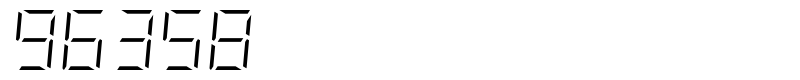

96358


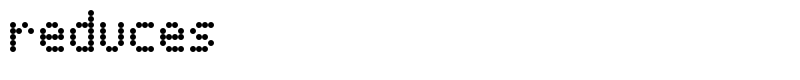

reduces


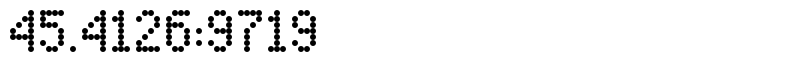

45.4126:9719


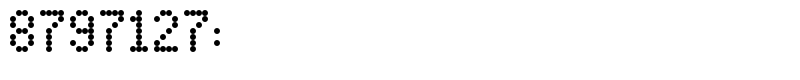

8797127:


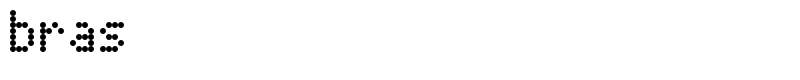

bras


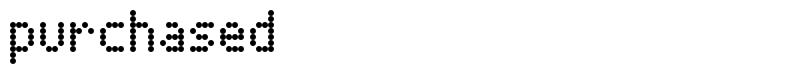

purchased


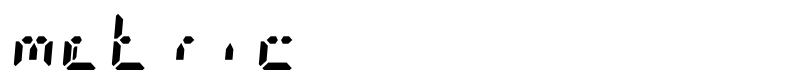

metric


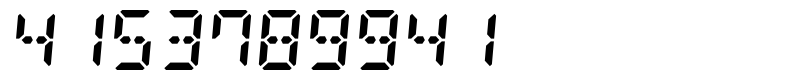

4153789941


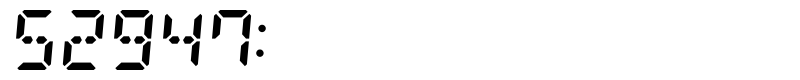

52947:


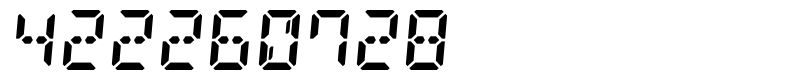

422260728


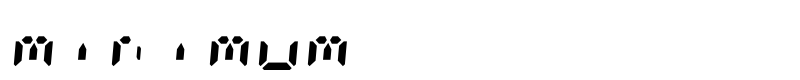

minimum


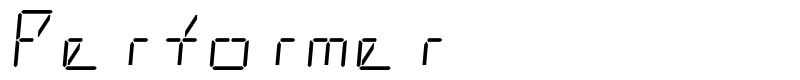

performer


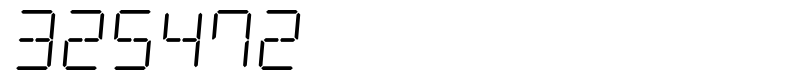

325472


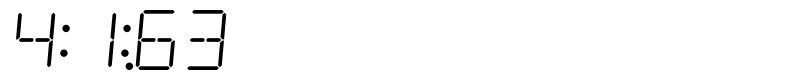

4:1:.63


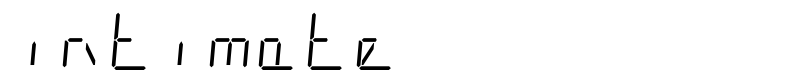

intimate


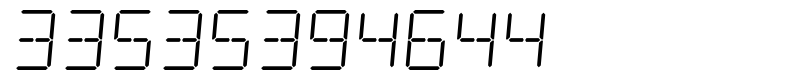

33535394644


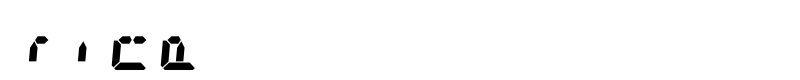

rica


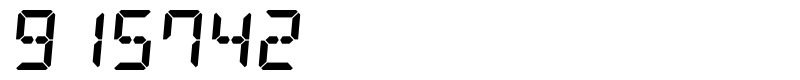

915742


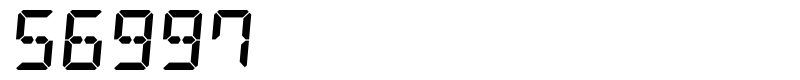

56997


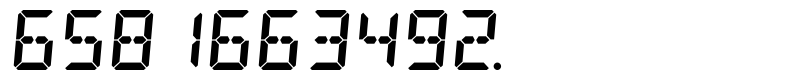

6581663492.


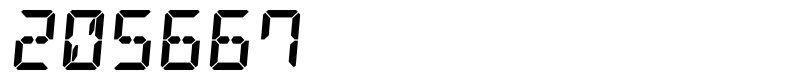

205667


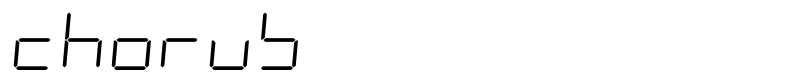

chorus


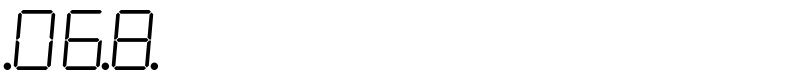

.06.8.


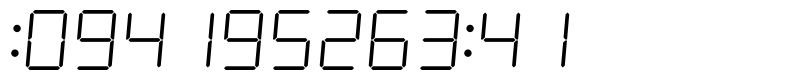

:094195263:41


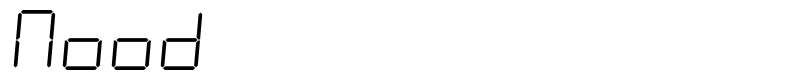

mood


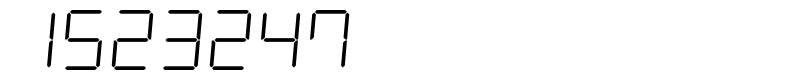

1523247


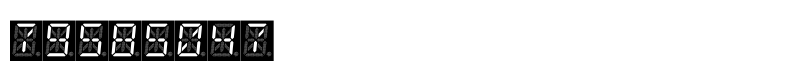

79585047


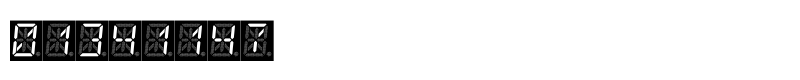

01341147


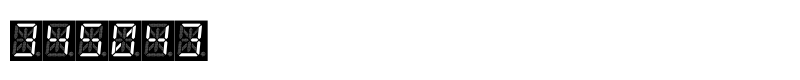

345043


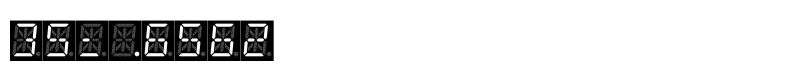

35:.6562


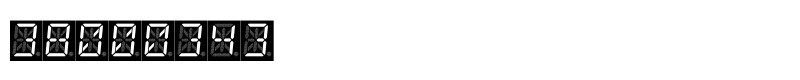

38000343


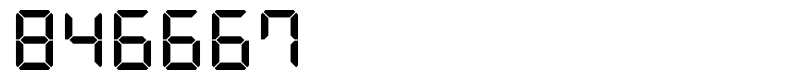

846667


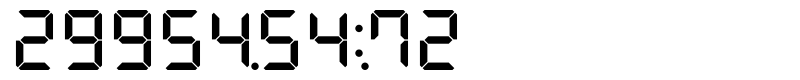

29954.54:.72


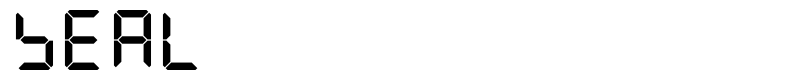

seal


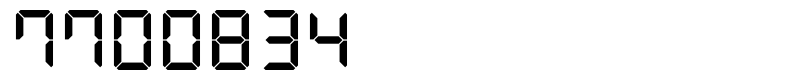

7700834


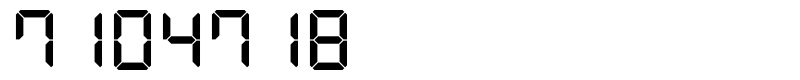

7104718


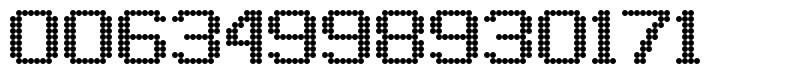

00634998930171


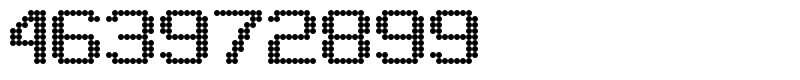

463972899


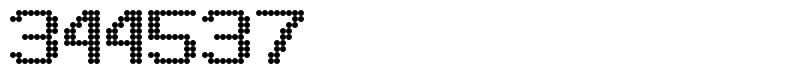

344537


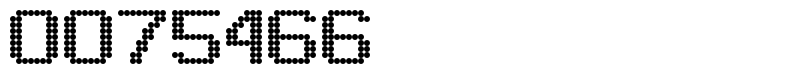

0075466


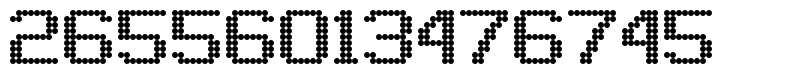

26556013476745


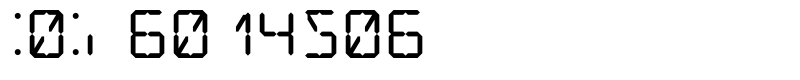

:0:.6014506


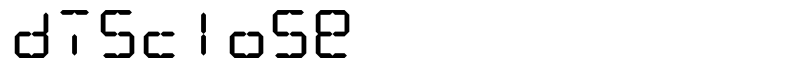

disclose


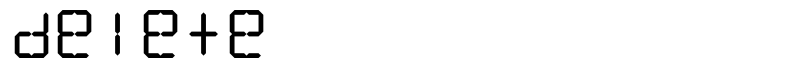

delete


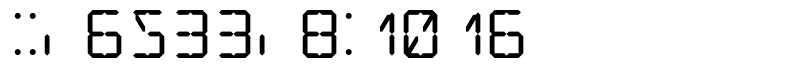

::.6533.8:1016


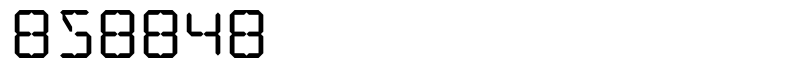

858848


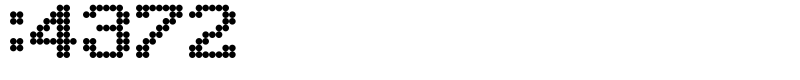

:4372


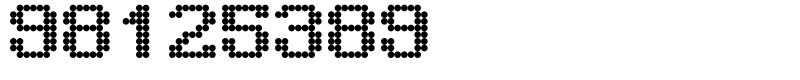

98125389


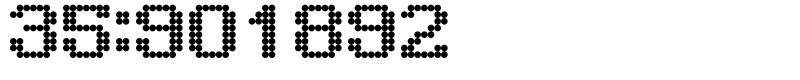

35:901892


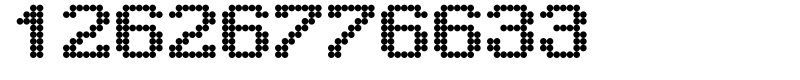

12626776633


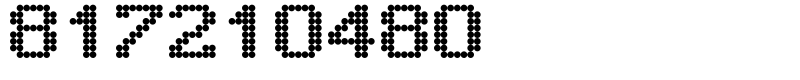

817210480


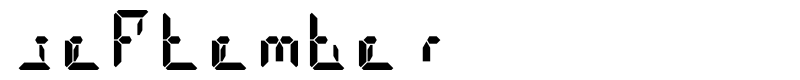

september


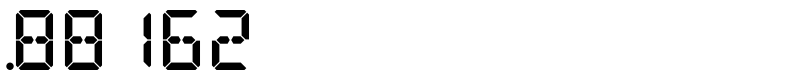

.88162


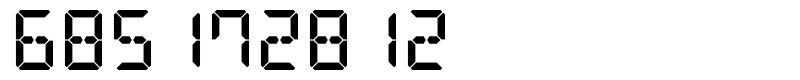

685172812


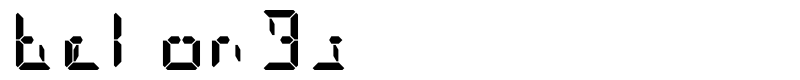

belongs


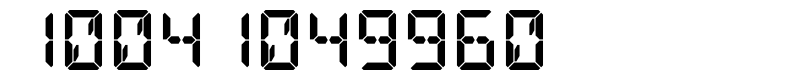

10041049960


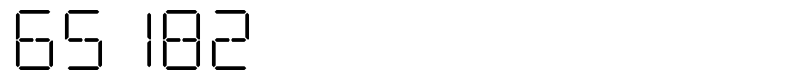

65182


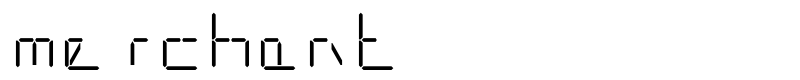

merchant


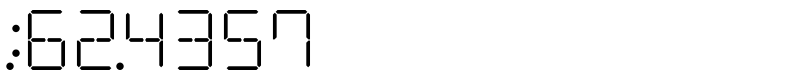

.:62.4357


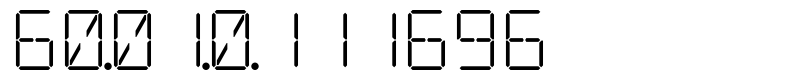

60.01.0.111696


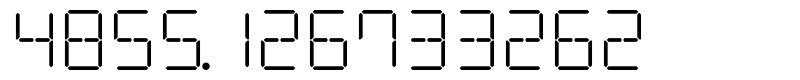

4855.126733262


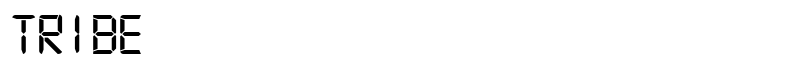

tribe


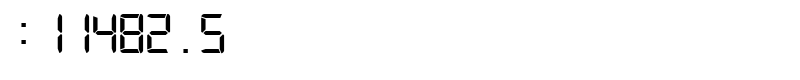

:11482.5


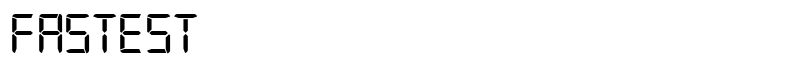

fastest


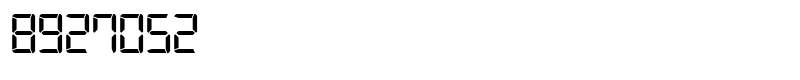

8927052


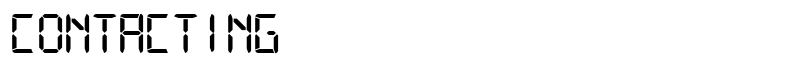

contacting


In [14]:
def draw_sample(font_path):
  word = sample_text(TTFont(font_path))
  font = ImageFont.truetype(font_path, 60)
  img = Image.new("RGBA", (800,80),(255,255,255))
  draw = ImageDraw.Draw(img)
  draw.text((10, 10),word,(0,0,0),font=font)
  draw = ImageDraw.Draw(img)
  return {'img': img, 'text': word}

def generate_data(fonts, sample_count):
  return pipe(
      fonts,
      mapcat(lambda font: pipe(
          range(sample_count),
          map(lambda _: font),
          map(draw_sample),
      )),
  )

font_paths = map(lambda f: os.path.join(paths['fonts'], f))(os.listdir(paths['fonts']))

for d in generate_data(font_paths, 5):
  display(d['img'])
  print(d['text'])